In [ ]:
!pip install --upgrade mxnet~=1.7 gluonts

     |████████████████████████████████| 2.1 MB 4.2 MB/s 
     |████████████████████████████████| 10.1 MB 36.9 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.


In [ ]:
'''
https://ts.gluon.ai/tutorials/forecasting/quick_start_tutorial.html
'''

In [ ]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [ ]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [ ]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [ ]:
dataset = get_dataset("m4_hourly", regenerate=True)

saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json
saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


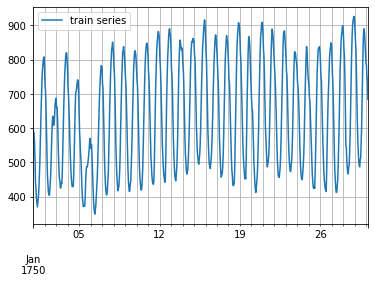

In [ ]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

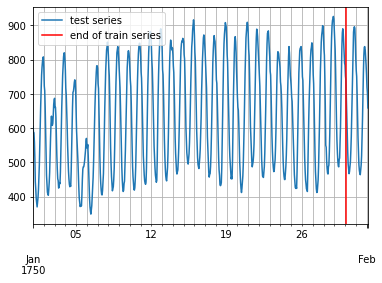

In [ ]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [ ]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


In [ ]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

In [ ]:
from gluonts.dataset.common import ListDataset

In [ ]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{'target': x, 'start': start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{'target': x, 'start': start} for x in custom_dataset],
    freq=freq
)

In [ ]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx import Trainer

In [ ]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

In [ ]:
predictor = estimator.train(dataset.train)

100%|██████████| 100/100 [00:01<00:00, 67.53it/s, epoch=5/5, avg_epoch_loss=4.76]


In [ ]:
from gluonts.evaluation import make_evaluation_predictions

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [ ]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [ ]:
# first entry of the time series list
ts_entry = tss[0]

In [ ]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([605., 586., 586., 559., 511.], dtype=float32)

In [ ]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [ ]:
# first 5 values
dataset_test_entry['target'][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

In [ ]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [ ]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


In [ ]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [643.3565  623.2073  518.67346 513.52954 477.7973  529.6269  448.32376
 481.06644 483.12573 559.54724 601.5694  642.2179  741.44763 784.579
 838.77405 920.9531  911.2327  869.3853  839.0142  859.5478  799.95703
 846.3192  766.0734  704.9913  648.6197  580.2664  559.2574  478.51114
 512.29285 469.76938 513.78107 519.4225  574.07715 558.49133 678.3697
 667.6041  739.3024  802.6311  867.84436 819.9532  845.6931  934.0447
 920.5934  899.95667 941.43884 794.6704  734.1722  708.85486]
0.5-quantile (median) of the future window:
 [652.692   614.918   531.24146 517.00073 461.17487 532.9029  457.73044
 499.22974 486.69907 547.57056 599.89355 635.53076 758.2811  793.08453
 837.5141  929.4019  918.09827 880.88446 841.5882  857.83453 829.0207
 822.99634 758.11    696.32855 654.5617  586.924   562.291   484.4486
 523.943   477.4343  510.31186 509.24808 569.3698  561.42676 666.5905
 650.34143 725.0971  803.3083  867.0963  840.8122  840.2934  945.27094
 917.04095 869.33685

In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

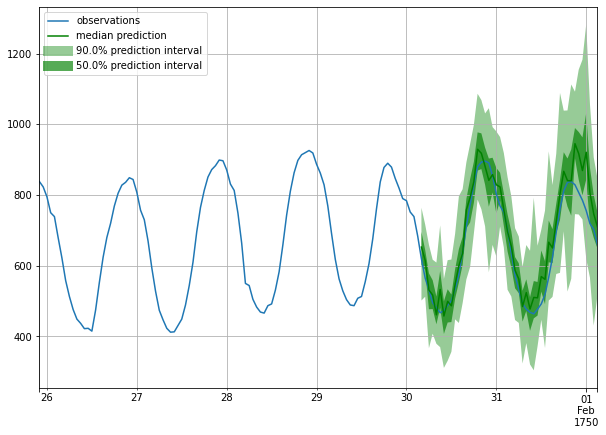

In [ ]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [ ]:
from gluonts.evaluation import Evaluator

In [ ]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 13307.70it/s]


In [ ]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 9163570.514467748,
    "abs_error": 9566325.656015396,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 3.2554645829157414,
    "MAPE": 0.2479637411937431,
    "sMAPE": 0.1860642869463386,
    "MSIS": 58.547655032604574,
    "QuantileLoss[0.1]": 4330627.561897755,
    "Coverage[0.1]": 0.10839371980676331,
    "QuantileLoss[0.5]": 9566325.421562195,
    "Coverage[0.5]": 0.5196256038647349,
    "QuantileLoss[0.9]": 6881306.748616789,
    "Coverage[0.9]": 0.8757045088566828,
    "RMSE": 3027.1389982073415,
    "NRMSE": 0.4132713370025081,
    "ND": 0.06572135436787697,
    "wQuantileLoss[0.1]": 0.029751726928908068,
    "wQuantileLoss[0.5]": 0.0657213527571664,
    "wQuantileLoss[0.9]": 0.04727507881309988,
    "mean_absolute_QuantileLoss": 6926086.577358913,
    "mean_wQuantileLoss": 0.04758271949972478,
    "MAE_Coverage": 0.017438271604938462,
    "OWA": NaN
}


In [ ]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,2924.826497,1827.066528,31644.0,659.250000,42.371302,0.898341,0.058677,0.056071,12.560742,859.653809,0.000000,1827.066620,0.812500,1419.825659,1.000000
1,1.0,183773.625000,19270.804688,124149.0,2586.437500,165.107988,2.431591,0.161383,0.146931,12.742166,4220.481128,0.291667,19270.804810,1.000000,8451.475879,1.000000
2,2.0,30389.911458,6327.100098,65030.0,1354.791667,78.889053,1.670886,0.088318,0.093629,12.195958,3192.731201,0.000000,6327.099792,0.187500,1812.205896,0.791667
3,3.0,189012.208333,16015.168945,235783.0,4912.145833,258.982249,1.288310,0.068020,0.067646,13.562011,8160.533691,0.020833,16015.169189,0.500000,7706.945996,0.979167
4,4.0,105765.979167,11604.915039,131088.0,2731.000000,200.494083,1.205866,0.087351,0.081981,12.342704,3817.444043,0.062500,11604.914673,0.770833,7419.854370,1.000000


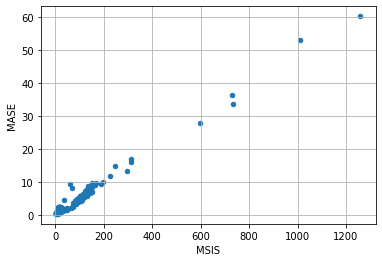

In [ ]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()